### Packages and Settings

In [1]:
import time
import datetime
import numpy as np
import pandas as pd
from itertools import product
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error
from sklearn import preprocessing
from sklearn.ensemble import RandomForestRegressor
import statsmodels.api as sm

## EDA & Feature Engineering

In [2]:
sales = pd.read_csv("/Users/roblespaeza96/Desktop/DT Certificate /Caps/capstone-project/sales_train.csv")
item_cat = pd.read_csv("/Users/roblespaeza96/Desktop/DT Certificate /Caps/capstone-project/item_categories.csv")
items = pd.read_csv("/Users/roblespaeza96/Desktop/DT Certificate /Caps/capstone-project/items.csv")
shop = pd.read_csv("/Users/roblespaeza96/Desktop/DT Certificate /Caps/capstone-project/shops.csv")
test = pd.read_csv("/Users/roblespaeza96/Desktop/DT Certificate /Caps/capstone-project/test.csv")
result = pd.read_csv("/Users/roblespaeza96/Desktop/DT Certificate /Caps/capstone-project/results - results.csv")

In [3]:
# First, let's visit the dataset sales_train.csv 
sales.date = sales.date.apply(lambda x: datetime.datetime.strptime(x, "%d.%m.%Y"))
print(sales.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2935849 entries, 0 to 2935848
Data columns (total 6 columns):
 #   Column          Dtype         
---  ------          -----         
 0   date            datetime64[ns]
 1   date_block_num  int64         
 2   shop_id         int64         
 3   item_id         int64         
 4   item_price      float64       
 5   item_cnt_day    float64       
dtypes: datetime64[ns](1), float64(2), int64(3)
memory usage: 134.4 MB
None


In [4]:
#So we have ~2M sales of items in the period we were given.
sales_monthly = sales.groupby(
    ["date_block_num", "shop_id", "item_id"])["date","item_price",
                                              "item_cnt_day"].agg({
        "date":["min","max"],
        "item_price":"mean",
        "item_cnt_day":"sum"})

<ipython-input-4-0336f043f654>:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  sales_monthly = sales.groupby(


In [5]:
sales_monthly.head(20)

date            item_price item_cnt_day
                                      min        max       mean          sum
date_block_num shop_id item_id                                              
0              0       32      2013-01-03 2013-01-31      221.0          6.0
                       33      2013-01-03 2013-01-28      347.0          3.0
                       35      2013-01-31 2013-01-31      247.0          1.0
                       43      2013-01-31 2013-01-31      221.0          1.0
                       51      2013-01-13 2013-01-31      128.5          2.0
                       61      2013-01-10 2013-01-10      195.0          1.0
                       75      2013-01-17 2013-01-17       76.0          1.0
                       88      2013-01-16 2013-01-16       76.0          1.0
                       95      2013-01-06 2013-01-06      193.0          1.0
                       96      2013-01-10 2013-01-10       70.0          1.0
                       98      2013-01-04 2013-01-31      268.0         25.0
                       111     2013-01-17 2013-01-17       89.0          1.0
                       149     2013-01-11 2013-01-28       99.0          3.0
                       151     2013-01-16 2013-01-16       75.0          1.0
                       153     2013-01-09 2013-01-09      258.0          1.0
                       198     2013-01-10 2013-01-10      112.0          1.0
                       210     2013-01-05 2013-01-25      118.0          2.0
                       282     2013-01-04 2013-01-04      109.0          1.0
                       306     2013-01-22 2013-01-22       59.0          1.0
                       351     2013-01-21 2013-01-21       89.0          1.0

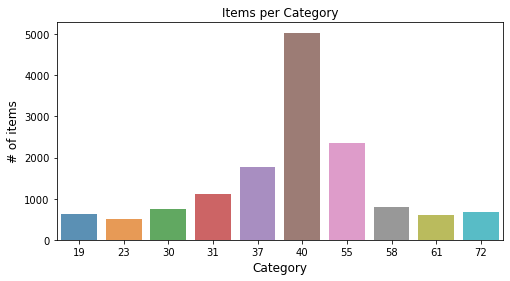

In [6]:
# number of items per cat 
items.head()
x = items.groupby(['item_category_id']).count() # but count is in column item_id ?
x = x.sort_values(by='item_id',ascending=False)
x=x.iloc[0:10].reset_index()
x
# plot
plt.figure(figsize=(8,4))
ax=sns.barplot(x.item_category_id, x.item_id, alpha=0.8)
plt.title("Items per Category")
plt.ylabel("# of items", fontsize=12)
plt.xlabel("Category", fontsize=12)
plt.show()

In [7]:
# sales category looks imbalanced, let's compute the total sales per month and plot that data.
ts = sales.groupby(['date_block_num'])['item_cnt_day'].sum()


out = sales.pivot_table(index='shop_id', 
                        columns='date_block_num',
                        values='item_cnt_day',
                        aggfunc='sum')
out = out.fillna(out.mean())
out.head()

date_block_num,0,1,2,3,4,5,6,7,8,9,...,24,25,26,27,28,29,30,31,32,33
shop_id,,,,,,,,,,,,,,,,,,,,,
0,5578.0,6127.0,3198.73913,2330.217391,2377.111111,2725.673913,2542.73913,2784.244444,2962.933333,2772.630435,...,2219.42,1791.446809,1782.913043,1655.893617,1643.068182,1491.023256,1469.465116,1573.309524,1694.023256,1614.909091
1,2947.0,3364.0,3198.73913,2330.217391,2377.111111,2725.673913,2542.73913,2784.244444,2962.933333,2772.630435,...,2219.42,1791.446809,1782.913043,1655.893617,1643.068182,1491.023256,1469.465116,1573.309524,1694.023256,1614.909091
2,1146.0,488.0,753.00000,583.000000,553.000000,832.000000,807.00000,875.000000,945.000000,795.000000,...,987.00,907.000000,762.000000,859.000000,843.000000,804.000000,785.000000,942.000000,822.000000,727.000000
3,767.0,798.0,959.00000,647.000000,710.000000,784.000000,721.00000,890.000000,1026.000000,793.000000,...,977.00,738.000000,741.000000,740.000000,731.000000,672.000000,535.000000,666.000000,745.000000,613.000000
4,2114.0,2025.0,2060.00000,285.000000,1211.000000,1464.000000,1378.00000,1713.000000,1536.000000,1482.000000,...,1188.00,980.000000,978.000000,899.000000,893.000000,793.000000,842.000000,947.000000,732.000000,831.000000


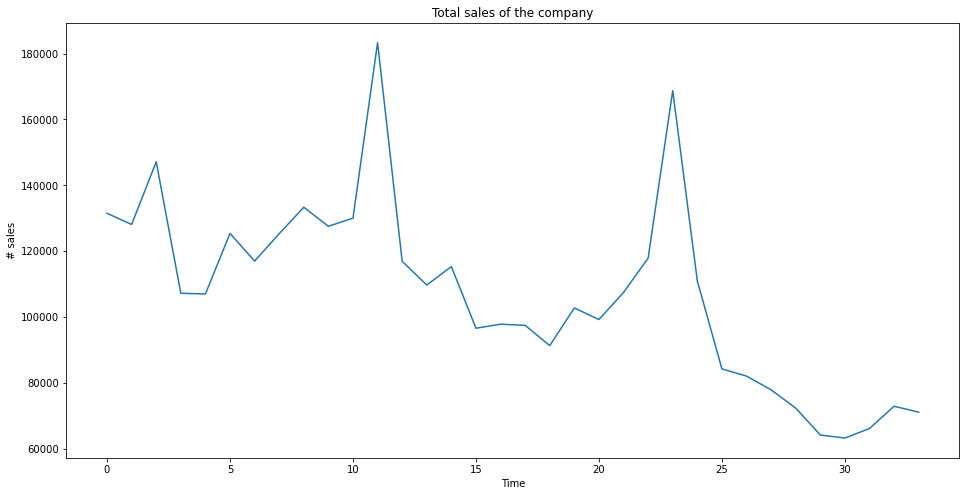

In [8]:
plt.figure(figsize=(16,8))
plt.plot(ts)
plt.title("Total sales of the company")
plt.xlabel("Time")
plt.ylabel("# sales")
plt.show()

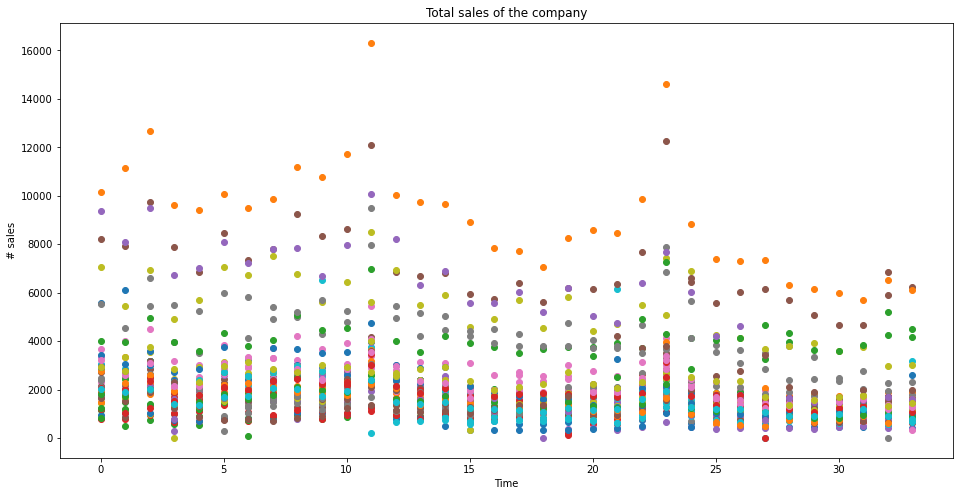

In [9]:
plt.figure(figsize=(16,8))
for i,row in out.iterrows():
    plt.scatter(out.columns, row)
plt.title("Total sales of the company")
plt.xlabel("Time")
plt.ylabel("# sales")
plt.show()

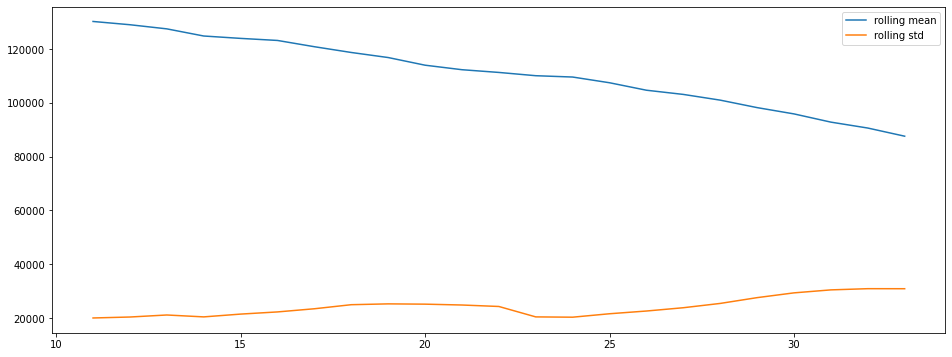

In [10]:
plt.figure(figsize=(16,6))
plt.plot(ts.rolling(window=12,center=False).mean(), label = "rolling mean")
plt.plot(ts.rolling(window=12, center=False).std(), label = "rolling std")
plt.legend()
plt.show()

<ipython-input-11-7abf04a93f76>:3: FutureWarning: the 'freq'' keyword is deprecated, use 'period' instead
  res = sm.tsa.seasonal_decompose(ts.values, freq=12, model="multiplicative")
<ipython-input-11-7abf04a93f76>:6: FutureWarning: the 'freq'' keyword is deprecated, use 'period' instead
  res = sm.tsa.seasonal_decompose(ts.values, freq=12, model="addidtive")


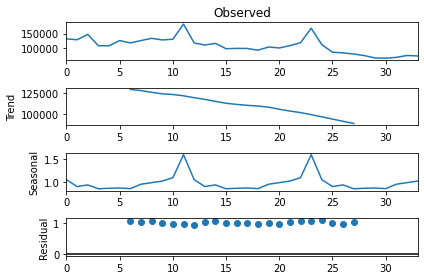

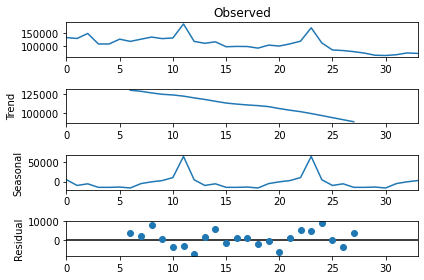

In [11]:
#Quick check onto Trend, seasonality and residuals.
import statsmodels.api as sm
res = sm.tsa.seasonal_decompose(ts.values, freq=12, model="multiplicative")
fig=res.plot()

res = sm.tsa.seasonal_decompose(ts.values, freq=12, model="addidtive")
fig=res.plot()

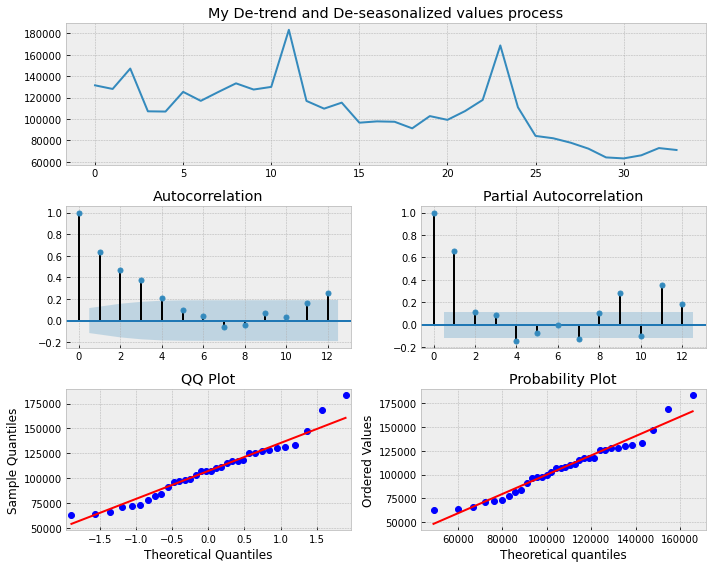

In [12]:
# We need to predict at the (shop,item_level)
import statsmodels.api as smt
import statsmodels
import scipy.stats as scs
from pandas import Series

ts = sales.groupby(["date_block_num"])["item_cnt_day"].sum()

def difference(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return Series(diff)

new_ts = difference(ts, 12)


def tsplot(y, lags=None, figsize=(10, 8), style='bmh',title=''):
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        #mpl.rcParams['font.family'] = 'Ubuntu Mono'
        layout = (3, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        qq_ax = plt.subplot2grid(layout, (2, 0))
        pp_ax = plt.subplot2grid(layout, (2, 1))
        
        y.plot(ax=ts_ax)
        ts_ax.set_title(title)
        statsmodels.graphics.tsaplots.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.5)
        statsmodels.graphics.tsaplots.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.5)
        smt.qqplot(y, line='s', ax=qq_ax)
        qq_ax.set_title('QQ Plot')        
        scs.probplot(y, sparams=(y.mean(), y.std()), plot=pp_ax)

        plt.tight_layout()
    return 

max_lag = 12
_ = tsplot(ts.values, lags=max_lag,title="My De-trend and De-seasonalized values process");

In [13]:
#ARMA
sales_monthly = sales.groupby(
    ["date_block_num", "shop_id", "item_id"])["date", "item_price",
                                              "item_cnt_day"].agg({
    "date": ["min", "max"],
    "item_price": "mean",
    "item_cnt_day": "sum"})

<ipython-input-13-bb783ef8c150>:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  sales_monthly = sales.groupby(


In [14]:
def overview(dataframe):
    
    data_resumen = {'Valores Unicos':dataframe.nunique(),'No-Nulos': dataframe.notnull().sum(), 'Nulos': dataframe.isnull().sum(), 'Formato': dataframe.dtypes, 'Min': dataframe.min(), 'Max': dataframe.max()}
    resumen = pd.DataFrame(data=data_resumen)
    return resumen

In [15]:
overview(sales_monthly)

Valores Unicos  No-Nulos  Nulos         Formato  \
date         min             1034   1609124      0  datetime64[ns]   
             max             1034   1609124      0  datetime64[ns]   
item_price   mean           41464   1609124      0         float64   
item_cnt_day sum              446   1609124      0         float64   

                                   Min                  Max  
date         min   2013-01-01 00:00:00  2015-10-31 00:00:00  
             max   2013-01-01 00:00:00  2015-10-31 00:00:00  
item_price   mean                 0.09               307980  
item_cnt_day sum                   -22                 2253

In [16]:
df1 = test.merge(result, left_on = 'ID', right_on = 'id')

We now find these couples iterating through test and creating the related SARIMAX model if we have enough data (at least 33 month of sales)